In [37]:
import numpy as np
import xarray as xr
import glob, os
import calendar
from scipy.ndimage.filters import gaussian_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import shapely.geometry as sgeom
%matplotlib inline

In [2]:
period = '2000_2019'
regions = ['asia','nam','spac']

obsdir = '/global/project/projectdirs/m1867/zfeng/gpm/mcs_region/'

syear = int(period[0:4])
eyear = int(period[5:9])

obsfiles_asia = []
obsfiles_spac = []
obsfiles_nam = []
for iyear in range(syear, eyear+1):
    datapath = f'{obsdir}/asia/stats_ccs4_4h/robust/filtered/'
    obsfiles_asia.extend(sorted(glob.glob(f'{datapath}robust_mcs_tracks_extc_{iyear}*nc')))
    datapath = f'{obsdir}/spac/stats_ccs4_4h/robust/filtered/'
    obsfiles_spac.extend(sorted(glob.glob(f'{datapath}robust_mcs_tracks_extc_{iyear}*nc')))
    datapath = f'{obsdir}/nam/stats_ccs4_4h/robust/filtered/'
    obsfiles_nam.extend(sorted(glob.glob(f'{datapath}robust_mcs_tracks_extc_{iyear}*nc')))
    
print(f'Number of files (Asia): {len(obsfiles_asia)}')
print(f'Number of files (SPAC): {len(obsfiles_spac)}')
print(f'Number of files (NAM): {len(obsfiles_nam)}')

topfile = '/global/project/projectdirs/m1867/zfeng/gpm/map_data/era5_orography.nc'

figdir = f'/global/project/projectdirs/m1867/zfeng/gpm/mcs_region/global/figures/ccs4_4h_{period}/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

Number of files (Asia): 20
Number of files (SPAC): 20
Number of files (NAM): 20
/global/project/projectdirs/m1867/zfeng/gpm/mcs_region/global/figures/ccs4_4h_2000_2019/


In [3]:
# Read topography data
dstop = xr.open_dataset(topfile)
# Convert surface geopotential to height in meters
ter = dstop.z.sel(latitude=slice(61,-61)).squeeze() / 9.80665
ter_s = gaussian_filter(ter, 1)
lon_ter = dstop.longitude
lat_ter = dstop.latitude.sel(latitude=slice(61,-61))
ter

<xarray.DataArray 'z' (latitude: 489, longitude: 1440)>
array([[-0.19099763, -0.2824136 ,  0.17526372, ...,  1.1824327 ,
         0.35849398,  0.26687884],
       [-0.19099763,  0.54152507,  0.35849398, ...,  2.2812166 ,
         1.3656629 ,  0.9994015 ],
       [-1.656043  , -0.9235203 ,  0.08384776, ...,  7.134229  ,
         0.9077864 , -0.55725896],
       ...,
       [ 0.35849398,  0.17526372,  0.17526372, ..., -0.46564385,
        -0.3740287 ,  0.17526372],
       [-0.3740287 , -0.0993825 ,  0.08384776, ...,  0.35849398,
         0.17526372,  0.17526372],
       [-0.00776737,  0.26687884, -0.00776737, ...,  0.08384776,
         0.17526372,  0.54152507]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 61.0 60.75 60.5 60.25 ... -60.5 -60.75 -61.0
    time       datetime64[ns] 1979-01-01

In [4]:
# Read MCS files (Asia)
dsasia = xr.open_mfdataset(obsfiles_asia, concat_dim='tracks', combine='nested')
ntracks = dsasia.dims['tracks']
ntimes = dsasia.dims['times']
# Replace tracks in dataset with monotonic increase array
dsasia['tracks'] = np.arange(0, dsasia.dims['tracks'], 1, dtype=int)
slat_ccs_asia = dsasia.meanlat.isel(times=0).load()
slon_ccs_asia = dsasia.meanlon.isel(times=0).load()
ntracks = dsasia.dims['tracks']
print(f'Total original tracks (Asia): {ntracks}')

# Only keep tracks initiated east of 40E
dsasia = dsasia.where(slon_ccs_asia > 40, drop=True)
ntracks = dsasia.dims['tracks']
print(f'After filter tracks (Asia): {ntracks}')

Total original tracks (Asia): 264266
After filter tracks (Asia): 256388


In [5]:
# Read MCS files (SPAC)
dsspac = xr.open_mfdataset(obsfiles_spac, concat_dim='tracks', combine='nested')
ntracks = dsspac.dims['tracks']
ntimes = dsspac.dims['times']
# Replace tracks in dataset with monotonic increase array
dsspac['tracks'] = np.arange(0, dsspac.dims['tracks'], 1, dtype=int)
slat_ccs_spac = dsspac.meanlat.isel(times=0).load()
slon_ccs_spac = dsspac.meanlon.isel(times=0).load()
ntracks = dsspac.dims['tracks']
print(f'Total original tracks (SPAC): {ntracks}')

# Only keep tracks initiated east of 40E, south of 25N
dsspac = dsspac.where((slon_ccs_spac < 40) & (slat_ccs_spac < 25), drop=True)
ntracks = dsspac.dims['tracks']
print(f'After filter tracks (SPAC): {ntracks}')

Total original tracks (SPAC): 276773
After filter tracks (SPAC): 260859


In [6]:
# Read MCS files (NAM)
dsnam = xr.open_mfdataset(obsfiles_nam, concat_dim='tracks', combine='nested')
ntracks = dsnam.dims['tracks']
ntimes = dsnam.dims['times']
# Replace tracks in dataset with monotonic increase array
dsnam['tracks'] = np.arange(0, dsnam.dims['tracks'], 1, dtype=int)
slat_ccs_nam = dsnam.meanlat.isel(times=0).load()
slon_ccs_nam = dsnam.meanlon.isel(times=0).load()
ntracks = dsnam.dims['tracks']
print(f'Total original tracks (NAM): {ntracks}')

# Only keep tracks initiated east of 40E
dsnam = dsnam.where((slon_ccs_nam < 40) & (slat_ccs_nam > 25), drop=True)
ntracks = dsnam.dims['tracks']
print(f'After filter tracks (NAM): {ntracks}')

Total original tracks (NAM): 57424
After filter tracks (NAM): 48155


In [7]:
# Combine regions into a global data
dsobs = xr.concat([dsasia, dsspac, dsnam], dim='tracks')
# Replace tracks in dataset with monotonic increase array
dsobs['tracks'] = np.arange(0, dsobs.dims['tracks'], 1, dtype=int)
ntracks = dsobs.dims['tracks']
print(f'Total tracks (OBS): {ntracks}')

# Only keep tracks in JJA
sseason_obs = dsobs.base_time.isel(times=0).dt.season
dsobs = dsobs.where(sseason_obs == 'JJA', drop=True)
ntracks = dsobs.dims['tracks']
print(f'Total JJA tracks (OBS): {ntracks}')

Total tracks (OBS): 565402
Total JJA tracks (OBS): 147918


In [8]:
# # Only keep tracks in a certain season
# sseason_obs = dsobs.base_time.isel(times=0).dt.season
# dsobs = dsobs.where(sseason_obs == 'JJA', drop=True)
# ntracks = dsobs.dims['tracks']
# print(f'Total JJA tracks (OBS): {ntracks}')

In [9]:
# Specificy the month value
month_val = 7

# Only keep tracks in a certain month
smonth_obs = dsobs.base_time.isel(times=0).dt.month
dsobs = dsobs.where(smonth_obs == month_val, drop=True)
ntracks = dsobs.dims['tracks']
print(f'Total subset tracks: {ntracks}')

Total subset tracks: 50902


In [11]:
# Get mean lat/lon throughout the lifetime of each MCS
# This way each MCS only get counted once
avglat_obs = dsobs.meanlat.mean(dim='times')
avglon_obs = dsobs.meanlon.mean(dim='times')

In [12]:
# plt.plot(avglon_obs, avglat_obs, 'o', markersize=0.5)

In [15]:
nyears_obs = len(np.unique(dsobs.base_time.isel(times=0).dt.year.values))
print(f'Number of unique years (OBS): {nyears_obs}')

bins = [180, 60]
ranges = [[-180,180], [-60,60]]
hist2d_avgloc_obs, xbins, ybins = np.histogram2d(avglon_obs.values, avglat_obs.values, bins=bins, range=ranges)
hist2d_avgloc_obs = hist2d_avgloc_obs.transpose()
# Divide the count by the number of years to get annual mean
mcs_number = hist2d_avgloc_obs / nyears_obs

lonbins = xbins[:-1] + np.diff(xbins)/2
latbins = ybins[:-1] + np.diff(ybins)/2

Number of unique years (OBS): 20


In [46]:
mcs_number.max()

5.45

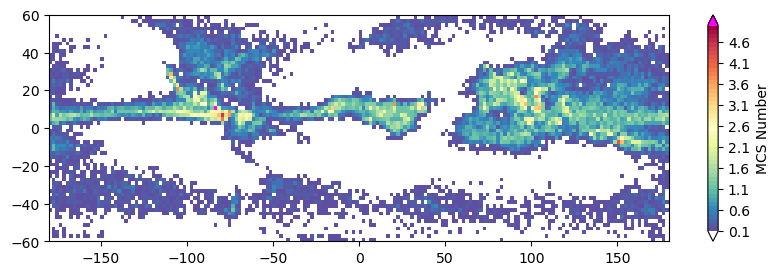

In [17]:
fig = plt.figure(figsize=[10,3], dpi=100)
levels = np.arange(0.1,5.01,0.1)
cbticks = levels
cblabel = 'MCS Number'
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
pcm = plt.pcolormesh(xbins, ybins, mcs_number, norm=norm, cmap='Spectral_r')
plt.colorbar(label=cblabel, extend='both')
pcm.cmap.set_over('magenta')
pcm.cmap.set_under('white')

In [18]:
# Get the number of days in the month in each year
ndays_all = []
for iyear in range(syear, eyear+1):
    ndays_all.append(calendar.monthrange(iyear, month_val)[1])
# Calculate the average number of days
ndays_avg = np.mean(ndays_all)
print(f'Average number of days: {ndays_avg}')

Average number of days: 31.0


In [19]:
# Get the largest PF center lat/lon at each MCS time
pf_lon = dsobs.pf_lon.isel(nmaxpf=0)
pf_lat = dsobs.pf_lat.isel(nmaxpf=0)

hist2d_pfloc_obs, xbins, ybins = np.histogram2d(pf_lon.values.ravel(), pf_lat.values.ravel(), bins=bins, range=ranges)
hist2d_pfloc_obs = hist2d_pfloc_obs.transpose()

# Divide the histogram count by the total number of hours (number of unique years * number of days in the month * 24 hours)
mcs_pffreq = 100 * hist2d_pfloc_obs / (nyears_obs * ndays_avg * 24)

In [20]:
np.max(mcs_pffreq)

12.271505376344086

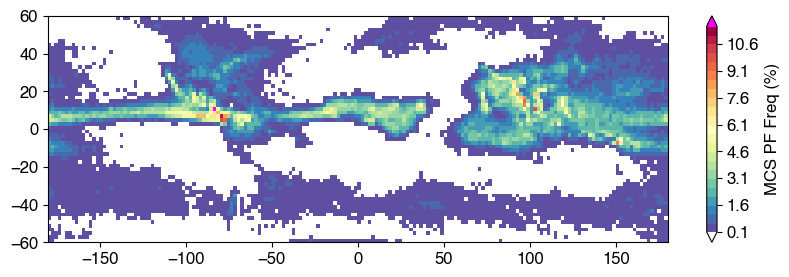

In [25]:
fig = plt.figure(figsize=[10,3], dpi=100)
levels = np.arange(0.1,12.01,0.5)
cbticks = levels
cblabel = 'MCS PF Freq (%)'
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
pcm = plt.pcolormesh(xbins, ybins, mcs_pffreq, norm=norm, cmap='Spectral_r')
# pcm = plt.contourf(lonbins, latbins, mcs_pffreq, levels=levels, norm=norm, extend='both', cmap='Spectral_r')
plt.colorbar(label=cblabel, extend='both')
pcm.cmap.set_over('magenta')
pcm.cmap.set_under('white')

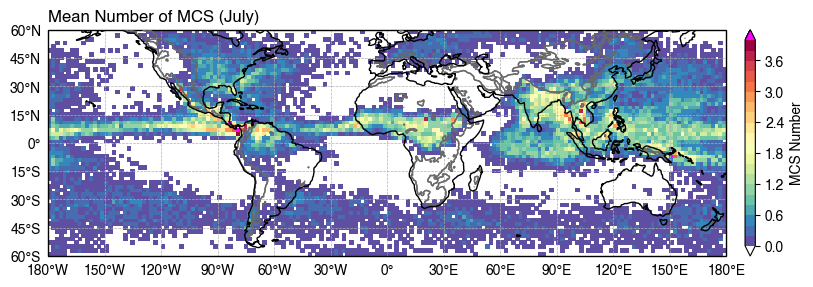

In [29]:
mpl.rcParams['font.size'] = 10
mpl.rcParams['font.family'] = 'Helvetica'

map_extend = [-180., 180., -60.1, 60.1]
lonvals = mpl.ticker.FixedLocator(np.arange(-180,180.1,30))
latvals = mpl.ticker.FixedLocator(np.arange(-90,90.1,15))
proj = ccrs.PlateCarree()
levelshgt = [1000,10000]

fig = plt.figure(figsize=[12,3], dpi=100)

resolution = '110m'
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)

ax = plt.subplot(111, projection=proj)
ax.set_extent(map_extend, crs=proj)
ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
# ax.add_feature(borders, facecolor='none', edgecolor='k', linewidth=1, zorder=3)
ax.set_title('Mean Number of MCS (July)', loc='left')
# Plot gridlines
gl = ax.gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = lonvals
gl.ylocator = latvals
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Terrain height
ct = ax.contour(lon_ter, lat_ter, ter_s, levels=[1000,1001], \
                colors='dimgray', linewidths=1, transform=proj, zorder=3)

levels = np.arange(0, 4.01, 0.2)
cmap = 'Spectral_r'
oob_colors = {'under':'white', 'over':'magenta'}

Zm = np.ma.masked_where(((mcs_number == 0) | (np.isnan(mcs_number))), mcs_number)
cmap = plt.get_cmap(cmap)
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
cf1 = ax.pcolormesh(xbins, ybins, Zm, norm=norm, cmap=cmap, transform=proj, zorder=2)
# cf1 = ax.contourf(xbins[:-1], ybins[:-1], Zm, levels=levels, norm=norm, cmap=cmap, transform=proj, zorder=2, extend='both')
cf1.cmap.set_over(oob_colors['over'])
cf1.cmap.set_under(oob_colors['under'])
cf1.set_clim(min(levels), max(levels))
# Colorbar
cb1 = plt.colorbar(cf1, pad=0.02, label='MCS Number', orientation='vertical', extend='both')
# Save figure
# fig.savefig(f'{figdir}mcs_number_from_MeanLatLon.png', dpi=300, bbox_inches='tight')

In [44]:
def plot_map_2seasons(dataarray, lon, lat, titles, levels, cmap, cblabels, cbticks, figname, oob_colors=None):
    
    mpl.rcParams['font.size'] = 8
    mpl.rcParams['font.family'] = 'Helvetica'
    fig = plt.figure(figsize=[10,6], dpi=150)

    map_extend = [-180., 180., -60.1, 60.1]
    lonvals = mpl.ticker.FixedLocator(np.arange(-180,180.1,30))
    latvals = mpl.ticker.FixedLocator(np.arange(-90,90.1,15))
    proj = ccrs.PlateCarree()

    resolution = '50m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)

    for pp in range(0,2):
        data = dataarray[pp]

        ax = plt.subplot(2, 1, pp+1, projection=proj)
        ax.set_extent(map_extend, crs=proj)
        ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
#         ax.add_feature(borders, facecolor='none', edgecolor='k', linewidth=1, zorder=3)
        ax.set_title(titles[pp], loc='left')
#         ax.set_aspect('auto', adjustable=None)
        # Plot gridlines
        gl = ax.gridlines(crs=proj, draw_labels=True, linestyle='--', linewidth=0.5)
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xlocator = lonvals
        gl.ylocator = latvals
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        # Terrain height
        ct = ax.contour(lon_ter, lat_ter, ter_s, levels=[1000,1001], \
                        colors='dimgray', linewidths=1, transform=proj, zorder=3)
        
        Zm = np.ma.masked_where(((data == 0) | (np.isnan(data))), data)
        cmap = plt.get_cmap(cmap)
        norm = mpl.colors.BoundaryNorm(boundaries=levels[pp], ncolors=cmap.N)
        cf1 = ax.pcolormesh(lon, lat, Zm, norm=norm, cmap=cmap, transform=proj, zorder=2)
#         cf1 = ax.contourf(lon, lat, Zm, levels=levels[pp], norm=norm, cmap=cmap, transform=proj, zorder=2, extend='both')
        # Colorbar
        cb1 = plt.colorbar(cf1, pad=0.02, label=cblabels[pp], orientation='vertical', extend='both')
        if oob_colors is not None:
            cf1.cmap.set_over(oob_colors['over'])
            cf1.cmap.set_under(oob_colors['under'])
            cf1.set_clim(min(levels[pp]), max(levels[pp]))
        # Plot missing region
        box_miss = sgeom.box(minx=-180, maxx=-75, miny=-60, maxy=-45)
        ax.add_geometries([box_miss], proj, facecolor='lightgray', edgecolor='none', zorder=2, alpha=0.9)
        ax.text(-128, -52.5, 'Missing Data', color='k', ha='center', va='center', transform=proj, zorder=3)
    
    fig.savefig(figname, dpi=300, bbox_inches='tight')
    return fig

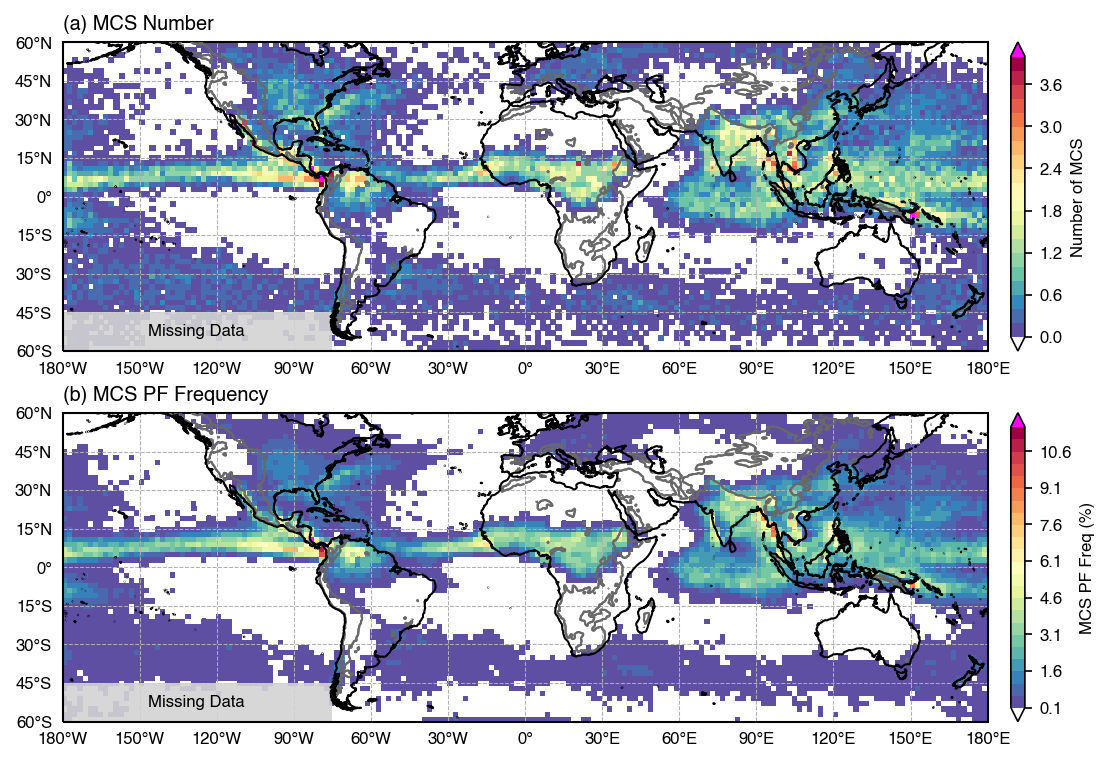

In [45]:
titles = [f'(a) MCS Number', f'(b) MCS PF Frequency']
dataarr = [mcs_number, mcs_pffreq]
# lonarr = [lonbins, lonbins]
# latarr = [latbins, latbins]
levels = [np.arange(0, 4.01, 0.2), np.arange(0.1, 12.01, 0.5)]
cbticks = levels
cblabels = ['Number of MCS', 'MCS PF Freq (%)']
cmap = plt.get_cmap('Spectral_r')
# cmap = truncate_colormap(cmap, 0., 0.9)
figname = f'{figdir}mcs_number_PFfreq_from_MeanLatLon.png'
oob_colors = {'under':'white', 'over':'magenta'}
# fig = plot_map_2seasons(dataarr, lonbins, latbins, titles, levels, cmap, cblabels, cbticks, figname, oob_colors=oob_colors)
fig = plot_map_2seasons(dataarr, xbins, ybins, titles, levels, cmap, cblabels, cbticks, figname, oob_colors=oob_colors)